In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

In [13]:
#Tworzymy deskryptor
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    #Dane nie zmienione
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    #Zmniejszenie romzmiaru danych
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #Zmniejszenie romzmiaru danych
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #Zmniejszenie romzmiaru danych
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #Klasyfikator 
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    #Kompilujemy stworzony model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [14]:
#Tworzymy generator
def define_generator(latent_dim):
    model = Sequential()
    #Baza rozmiaru zdjęcia o wymiarach 4x4
    model.add(Dense(256 * 4 * 4, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    #Zwiększenie wymiaru do 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #Zwiększenie wymiaru do 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #Zwiększenie wymiaru do 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
   
    #Warstwa wyjściowa
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

In [27]:
#Definiujemy model generatora jak i deskryptor
def define_gan(g_model, d_model):
    #Ustawiamy wagi w dyskryminatorze na nie trenowalne
    d_model.trainable = False

    #Łączymy modele generatora i deskryptor
    model = Sequential()
    model.add(g_model)
    model.add(d_model)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [16]:
#Wczytujemy zbiór CIFAR10 
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    #Normalizujemy dane do przedziału -1/1]
    X = (X - 127.5) / 127.5 
    return X

In [17]:
def generate_real_samples(dataset, n_samples):
    #Generowanie losowych danych ze zbioru
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]

    #Generujemy prawdziwe oznaczenia
    y = ones((n_samples, 1))
    return X, y

In [18]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [19]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    #Dokonujemy predykcji
    X = g_model.predict(x_input)
    #Generujemy fałszywe oznaczenia
    y = zeros((n_samples, 1))
    return X, y

In [20]:
def save_plot(examples, epoch, n=7):
    #Skalujemu z przedziały [-1,1] do [0,1]
    examples = (examples + 1) / 2.0

    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])

    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.show()

In [28]:
#Ocenianie deskrpytora
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    #Generujemy prawdziwe obrazy
    X_real, y_real = generate_real_samples(dataset, n_samples)
    #Oceniamy nasz deskryptor na prawdziwych próbkach
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  
    #Generujemy fałszywe obrazy
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    #Analogicznie oceniemy deskrpytor, tym razem na wygenerowanych obrazach
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    #Wyliczamy dokladność naszego dyskryptora
    print('[Dokładność] PRAWDZIWE: %.0f%%, GENEROWANE: %.0f%%' % (acc_real * 100, acc_fake * 100))

    save_plot(x_fake, epoch)
    filename = 'generator_model.h5'
    g_model.save(filename)

In [29]:
#Trenowanie modelu GAN
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
 
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            #Wybieramu losową próbke ze zbioru prawdziwych obrazów
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            #Generjemy nowe obrazy - "fałszywe"
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

   
            X_gan = generate_latent_points(latent_dim, n_batch)
            #Zamieniamy oznaczenia dla generowanych próbek
            y_gan = ones((n_batch, 1))

            #Aktualizujemy nasz generator 
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            #Liczymy funkcje strat na naszej próbce
            if j % 100 == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

4/4 [==============================] - 0s 7ms/step
>1, 1/195, d1=0.681, d2=0.697 g=0.690
4/4 [==============================] - 0s 4ms/step
>1, 101/195, d1=0.231, d2=0.135 g=6.441
5/5 [==============================] - 0s 3ms/step
[Dokładność] PRAWDZIWE: 97%, GENEROWANE: 92%


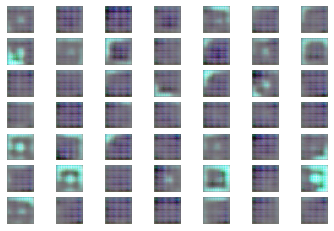

4/4 [==============================] - 0s 7ms/step
>2, 1/195, d1=0.133, d2=0.402 g=1.588
4/4 [==============================] - 0s 4ms/step
>2, 101/195, d1=0.381, d2=0.478 g=1.437
5/5 [==============================] - 0s 4ms/step
[Dokładność] PRAWDZIWE: 71%, GENEROWANE: 99%


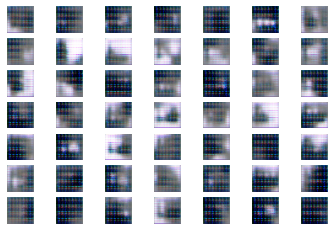

4/4 [==============================] - 0s 5ms/step
>3, 1/195, d1=0.635, d2=0.479 g=2.049
4/4 [==============================] - 0s 5ms/step
>3, 101/195, d1=0.762, d2=0.602 g=1.643
5/5 [==============================] - 0s 4ms/step
[Dokładność] PRAWDZIWE: 77%, GENEROWANE: 90%


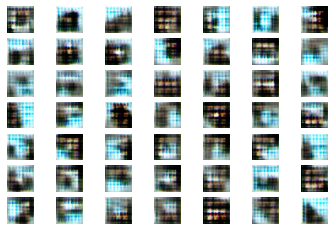

4/4 [==============================] - 0s 3ms/step
>4, 1/195, d1=0.427, d2=0.376 g=1.768
4/4 [==============================] - 0s 5ms/step
>4, 101/195, d1=0.565, d2=0.556 g=1.347
5/5 [==============================] - 0s 4ms/step
[Dokładność] PRAWDZIWE: 66%, GENEROWANE: 87%


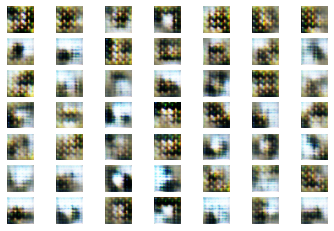

4/4 [==============================] - 0s 4ms/step
>5, 1/195, d1=0.644, d2=0.573 g=1.249
4/4 [==============================] - 0s 5ms/step
>5, 101/195, d1=0.570, d2=0.621 g=1.164
5/5 [==============================] - 0s 5ms/step
[Dokładność] PRAWDZIWE: 55%, GENEROWANE: 60%


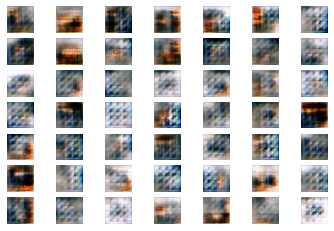

4/4 [==============================] - 0s 4ms/step
>6, 1/195, d1=0.682, d2=0.723 g=1.067
4/4 [==============================] - 0s 6ms/step
>6, 101/195, d1=0.641, d2=0.553 g=1.109
5/5 [==============================] - 0s 5ms/step
[Dokładność] PRAWDZIWE: 40%, GENEROWANE: 84%


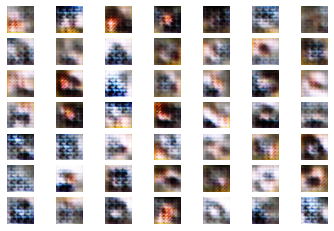

4/4 [==============================] - 0s 4ms/step
>7, 1/195, d1=0.714, d2=0.569 g=1.120
4/4 [==============================] - 0s 4ms/step
>7, 101/195, d1=0.611, d2=0.537 g=1.218
5/5 [==============================] - 0s 5ms/step
[Dokładność] PRAWDZIWE: 77%, GENEROWANE: 95%


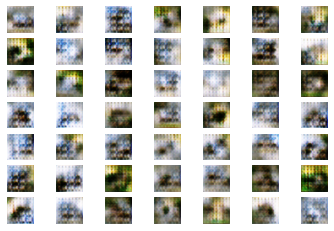

4/4 [==============================] - 0s 5ms/step
>8, 1/195, d1=0.494, d2=0.507 g=1.331
4/4 [==============================] - 0s 4ms/step
>8, 101/195, d1=0.523, d2=0.680 g=1.054
5/5 [==============================] - 0s 6ms/step
[Dokładność] PRAWDZIWE: 69%, GENEROWANE: 78%


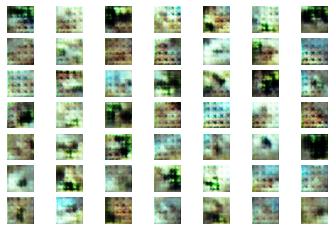

4/4 [==============================] - 0s 4ms/step
>9, 1/195, d1=0.678, d2=0.651 g=1.163
4/4 [==============================] - 0s 4ms/step
>9, 101/195, d1=0.597, d2=0.545 g=1.150
5/5 [==============================] - 0s 4ms/step
[Dokładność] PRAWDZIWE: 59%, GENEROWANE: 71%


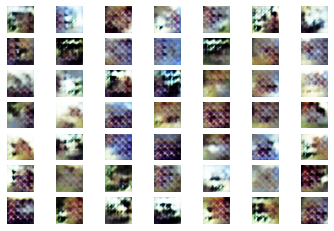

4/4 [==============================] - 0s 5ms/step
>10, 1/195, d1=0.734, d2=0.663 g=1.124
4/4 [==============================] - 0s 4ms/step
>10, 101/195, d1=0.654, d2=0.560 g=1.167
5/5 [==============================] - 0s 4ms/step
[Dokładność] PRAWDZIWE: 57%, GENEROWANE: 90%


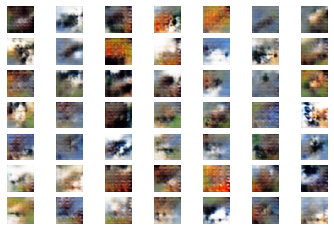

4/4 [==============================] - 0s 4ms/step
>11, 1/195, d1=0.644, d2=0.629 g=1.043
4/4 [==============================] - 0s 7ms/step
>11, 101/195, d1=0.636, d2=0.559 g=1.178
5/5 [==============================] - 0s 4ms/step
[Dokładność] PRAWDZIWE: 55%, GENEROWANE: 89%


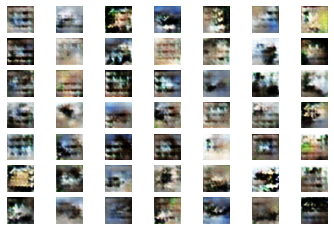

4/4 [==============================] - 0s 4ms/step
>12, 1/195, d1=0.671, d2=0.661 g=1.179
4/4 [==============================] - 0s 7ms/step
>12, 101/195, d1=0.627, d2=0.636 g=1.004
5/5 [==============================] - 0s 4ms/step
[Dokładność] PRAWDZIWE: 49%, GENEROWANE: 77%


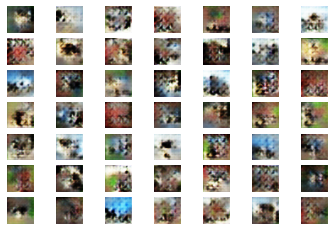

4/4 [==============================] - 0s 6ms/step
>13, 1/195, d1=0.769, d2=0.636 g=1.158
4/4 [==============================] - 0s 6ms/step
>13, 101/195, d1=0.642, d2=0.568 g=1.131
5/5 [==============================] - 0s 5ms/step
[Dokładność] PRAWDZIWE: 45%, GENEROWANE: 87%


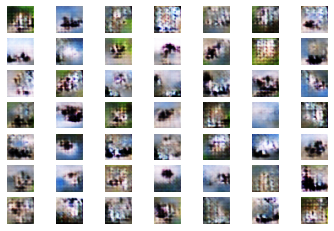

4/4 [==============================] - 0s 4ms/step
>14, 1/195, d1=0.754, d2=0.548 g=1.155
4/4 [==============================] - 0s 4ms/step
>14, 101/195, d1=0.550, d2=0.648 g=1.156
5/5 [==============================] - 0s 3ms/step
[Dokładność] PRAWDZIWE: 66%, GENEROWANE: 89%


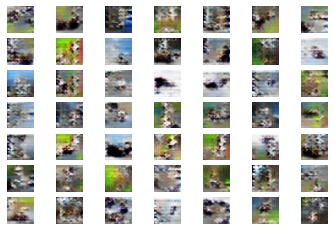

4/4 [==============================] - 0s 5ms/step
>15, 1/195, d1=0.618, d2=0.543 g=1.096
4/4 [==============================] - 0s 6ms/step
>15, 101/195, d1=0.491, d2=0.665 g=1.237
5/5 [==============================] - 0s 4ms/step
[Dokładność] PRAWDZIWE: 65%, GENEROWANE: 87%


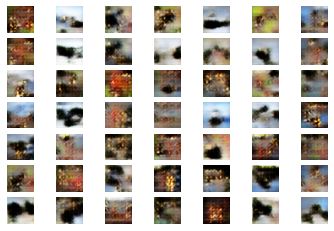

4/4 [==============================] - 0s 5ms/step
>16, 1/195, d1=0.567, d2=0.558 g=1.147
4/4 [==============================] - 0s 4ms/step
>16, 101/195, d1=0.645, d2=0.655 g=1.251
5/5 [==============================] - 0s 5ms/step
[Dokładność] PRAWDZIWE: 67%, GENEROWANE: 73%


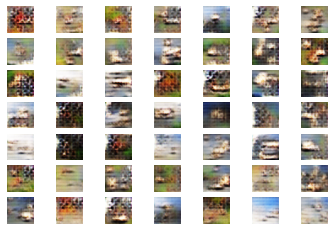

4/4 [==============================] - 0s 5ms/step
>17, 1/195, d1=0.556, d2=0.505 g=1.299
4/4 [==============================] - 0s 5ms/step
>17, 101/195, d1=0.647, d2=0.565 g=1.077
5/5 [==============================] - 0s 5ms/step
[Dokładność] PRAWDZIWE: 69%, GENEROWANE: 83%


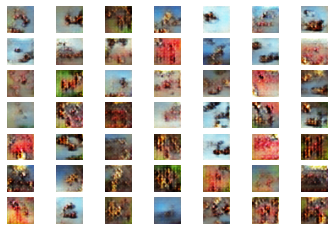

4/4 [==============================] - 0s 4ms/step
>18, 1/195, d1=0.562, d2=0.532 g=1.157
4/4 [==============================] - 0s 8ms/step
>18, 101/195, d1=0.645, d2=0.712 g=1.084
5/5 [==============================] - 0s 6ms/step
[Dokładność] PRAWDZIWE: 46%, GENEROWANE: 80%


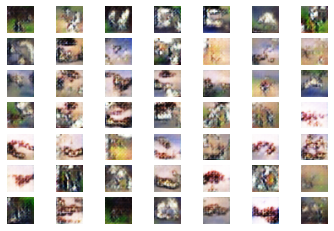

4/4 [==============================] - 0s 7ms/step
>19, 1/195, d1=0.718, d2=0.617 g=1.016
4/4 [==============================] - 0s 5ms/step
>19, 101/195, d1=0.586, d2=0.577 g=1.015
5/5 [==============================] - 0s 4ms/step
[Dokładność] PRAWDZIWE: 54%, GENEROWANE: 75%


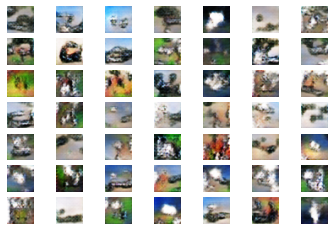

4/4 [==============================] - 0s 4ms/step
>20, 1/195, d1=0.622, d2=0.642 g=0.970
4/4 [==============================] - 0s 4ms/step
>20, 101/195, d1=0.645, d2=0.691 g=0.885
5/5 [==============================] - 0s 5ms/step
[Dokładność] PRAWDZIWE: 45%, GENEROWANE: 84%


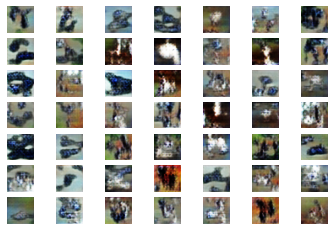

In [30]:
latent_dim = 100

#Tworzymy deskryptor oraz nasz generator
d_model = define_discriminator()
g_model = define_generator(latent_dim)

#Tworzymy model GAN
gan_model = define_gan(g_model, d_model)


dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim, 20, 256)